In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import FOLPSD as FOLPS
import time

In [2]:
import os, sys

sys.path.append(os.path.abspath("../.."))

# Select the backend before importing folps.py
os.environ["FOLPS_BACKEND"] = "numpy"  #'numpy' or 'jax'

from folps import *
from cosmo_class import *

✅ Using NumPy with CPU.


## FOLPSD (AA)

In [3]:
#omega_i = Omega_i h² 
omega_b = 0.0224;        #baryons
omega_cdm = 0.12;       #CDM
omega_ncdm = 0.00;    #massive neutrinos 
h = 0.67;                 #h = H0/100
z_pk = 0.01;                 #evaluation redshift
CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]

Linear power spectrum at redshift z_pk:

In [4]:
inputpkT = np.loadtxt('pk_linear.txt', unpack = True)

Nuisance parameters for the linear power spectrum:

Define a vector with the nuisances parameters, NuisanParams = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP]

In [6]:
#bias parameters
b1 = 1;                 
b2 = 2;                 
bs2 = -4/7*(b1 - 1);        
b3nl = 32/315*(b1 - 1);  

#EFT parameters
alpha0, alpha2, alpha4 = -10,-3,2#-10,-3,2    # PEFT(k) = (alpha0 + alpha2*mu^2+ alpha4*mu^4)  k^2 Plin(k)
ctilde = 0               #NLO counterterm
X_FoG = 5  # uses a Lorentzian Damping 1/(1+x^2), with x = X_FoG f sigma_v mu. 

#Stochatics parameters
# Noise is Pshot = PshotP * ( alphashot0 + alphashot2*(k*mu)**2 )
alphashot0 = 2;          
alphashot2 = 1;            
PshotP = 1/0.002    # =1/barn.  Poissonian shot noise
NuisanParams = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP,X_FoG]

#### Computation of $M$ matrices 
**They do not depend on the cosmology**, so they are **computed only one time**. That is, the first time the code is called, it computes the $M$ matrices and stores them for the rest of the runs, which can be of the order of thousands in parameter estimations.

In [7]:
matrices = FOLPS.Matrices()

N = 128 sampling points
M matrices have been computed


In [8]:
Omfid = -1  # for AP set > 0

In [9]:
# output k_ev
k_ev = np.logspace(np.log10(0.01), np.log10(0.3), num = 100) # array of k_ev in [h/Mpc]

In [10]:
# Compute 1loop integrals
nonlinear = FOLPS.NonLinear(inputpkT, CosmoParams, EdSkernels=True)

In [11]:
kh, pkl0, pkl2, pkl4 = FOLPS.RSDmultipoles(k_ev, NuisanParams, Omfid = Omfid, AP=False)

=========== mu ============
-0.9815606342467194
=========== W: damping ============
[0.97652422 0.97489638 0.97315877 0.97130443 0.96932601 0.9672158
 0.96496567 0.96256707 0.96001106 0.95728826 0.95438888 0.9513027
 0.94801906 0.94452693 0.94081484 0.93687095 0.93268305 0.92823861
 0.92352481 0.91852854 0.91323652 0.90763532 0.90171145 0.8954514
 0.8888418  0.88186947 0.87452154 0.86678559 0.8586498  0.85010306
 0.84113516 0.83173692 0.82190042 0.81161913 0.80088811 0.78970419
 0.77806615 0.76597492 0.7534337  0.74044813 0.72702645 0.71317957
 0.69892117 0.68426776 0.66923868 0.65385609 0.63814492 0.62213275
 0.60584967 0.58932809 0.57260253 0.55570932 0.53868634 0.52157265
 0.50440817 0.4872333  0.47008852 0.45301404 0.43604941 0.41923316
 0.40260245 0.38619277 0.37003765 0.35416838 0.33861386 0.3234004
 0.30855158 0.29408819 0.28002821 0.26638676 0.25317616 0.24040601
 0.22808327 0.21621237 0.2047954  0.1938322  0.18332059 0.17325652
 0.16363425 0.15444655 0.14568486 0.13733948 0.12

## folps.py (HN)

In [12]:
kwargs = {'z': z_pk, 
          'h': h, 
          'Omega_m': (omega_b + omega_cdm + omega_ncdm)/h**2, 
          #'f0':0.535274946761771,
          'fnu':omega_ncdm/(omega_b + omega_cdm + omega_ncdm)
         }

In [13]:
matrix = MatrixCalculator(A_full=False)
mmatrices = matrix.get_mmatrices()

Loading matrices from matrices_nfftlog128_Afull_False_remove-DeltaP_False.npy


In [14]:
qpar, qper = 1, 1#qpar_qperp(Omega_fid=Omfid, Omega_m=kwargs['Omega_m'], z_pk=kwargs['z'])

In [15]:
nonlinear = NonLinearPowerSpectrumCalculator(mmatrices=mmatrices,
                                             kernels='eds',
                                             **kwargs)

In [16]:
table, table_now = nonlinear.calculate_loop_table(k=inputpkT[0], pklin=inputpkT[1],cosmo=None, **kwargs)

In [17]:
multipoles = RSDMultipolesPowerSpectrumCalculator(model='FOLPSD') 

In [18]:
P0, P2, P4  = multipoles.get_rsd_pkell(kobs=k_ev, qpar=qpar, qper=qper, pars=NuisanParams,
                                       table=table, table_now=table_now,
                                       bias_scheme='folps', damping='lor', 
                                       )

[FOLPS] Model Pk: FOLPSD, Damping: lor


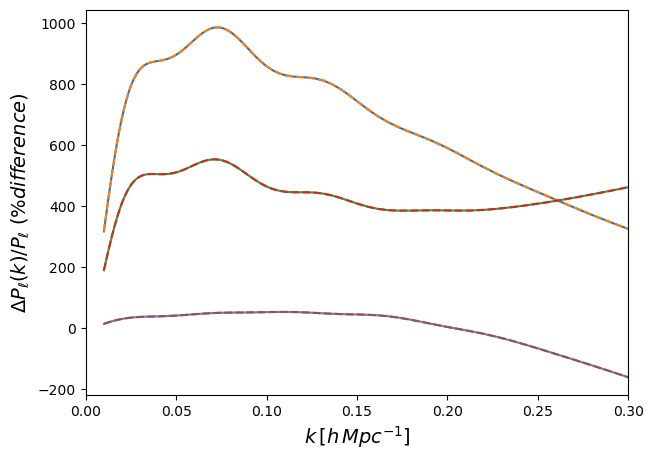

In [19]:
fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$\Delta P_{\ell}(k)/P_{\ell}\,\, (\% difference)$', fontsize =  14)

axs.plot(kh,  kh*pkl0, label=r'$\ell = 0$')
axs.plot(kh,  kh*P0, label=r'$folpspy$', ls = '--')

axs.plot(kh,  kh*pkl2, label=r'$\ell = 0$')
axs.plot(kh,  kh*P2, label=r'$folpspy$', ls = '--')

axs.plot(kh,  kh*pkl4, label=r'$\ell = 0$')
axs.plot(kh,  kh*P4, label=r'$folpspy$', ls = '--')

#axs.plot(kh, kh * pkl2, label=r'$\ell = 2$')



axs.set_xlim([0, 0.3])
plt.show()

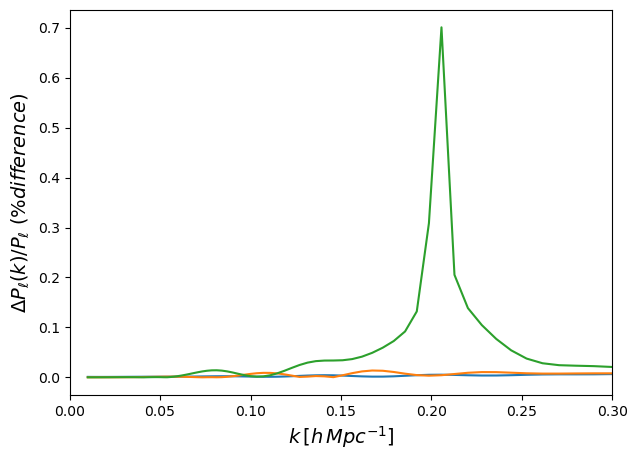

In [20]:
fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$\Delta P_{\ell}(k)/P_{\ell}\,\, (\% difference)$', fontsize =  14)

axs.plot(kh,  100*abs(1-pkl0/P0), label=r'$\ell = 0$')
axs.plot(kh,  100*abs(1-pkl2/P2), label=r'$\ell = 2$')
axs.plot(kh,  100*abs(1-pkl4/P4), label=r'$\ell = 4$')

#axs.plot(kh, kh * pkl2, label=r'$\ell = 2$')



axs.set_xlim([0, 0.3])
plt.show()


# Run Bispectrum

In [ ]:
# niusance parameters for the bispectrum
Pshot = 0; # This would be the same as PshopP*alphashot0 if the bispectrum were computed up to 1loop (I think!)
Bshot = 0;
c1=0
c2=0
X_FoG_bk=0

bisp_nuis_params = [b1, b2, bs2, c1,c2,Pshot,Bshot, X_FoG_bk]
bisp_cosmo_params = [(omega_cdm+omega_b+omega_ncdm)/h**2,h]

In [ ]:
k_ev = np.logspace(np.log10(0.01), np.log10(0.3), num = 30) # array of k_ev in [h/Mpc]
k_ev_bk=np.vstack([k_ev,k_ev]).T   # List of pairs of k. (B=B(k1,k2))

In [ ]:
Omfid = -1 # for AP

In [ ]:
k_pkl_pklnw=np.array([nonlinear[0][0], nonlinear[0][1], nonlinear[1][1]])
B000, B202 = FOLPS.Bisp_Sugiyama(bisp_cosmo_params, bisp_nuis_params,
                                   k_pkl_pklnw=k_pkl_pklnw, z_pk=z_pk, k1k2pairs=k_ev_bk,
                                   Omfid=Omfid,precision=[10,8,8])

In [ ]:
fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize =  14)

axs.plot(k_ev, k_ev**2 * B000, label=r'B000')
axs.plot(k_ev, k_ev**2 * B202,label=r'B202')

axs.set_xlim([0, 0.20])
plt.show()